In [1]:
import numpy as np
from copy import deepcopy
from pprint import pprint
import sys, os, time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm


sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')

from futils import extract_weights, get_ei, gaussian_mixture_modeling, jthreshold, permute_weights
from modeling_analysis_utils import extract_top_J, load_simulation_parameters, plot_example_traces
from rnn_modeling_utils import solve_stochastic_euler
from graph_utils import generate_snap_unweighted_graph, leiden_clustering, run_motif_counting_algorithm, read_motif_counts
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

## ei analysis, modularity analysis, motif analysis

In [3]:
FISH_ID = 2
version = 1

def acquire_info(date, state, idx):
    J_filepath           = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/training-%s' % (FISH_ID, state, version, date)
    parameters_filepath  = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/additional-info-%s.npz' % (FISH_ID, state, version, date)

    f = np.load(J_filepath + '/full-%s-%i.npz' % (state,idx), allow_pickle=True)
    J = f['J']
    N = J.shape[0]
    f.close()

    simulation_kwargs = load_simulation_parameters(parameters_filepath)
    simulation_kwargs['J'] = J

    Ytruth = simulation_kwargs['Ytruth']
    currents    = solve_stochastic_euler(**simulation_kwargs)
    activations = np.tanh(currents)
    Ymodel      = np.matmul(J, activations)


    simulation_kwargs['H'] = np.zeros_like(simulation_kwargs['H'], dtype='float32')
    currents_naked    = solve_stochastic_euler(**simulation_kwargs)
    activations_naked = np.tanh(currents_naked)
    Ymodel_naked     = np.matmul(J, activations_naked)
    
    return {'spatial': simulation_kwargs['spatial'], 'S': simulation_kwargs['S'], 'J': J, 'Ytruth': Ytruth, 'Ymodel': Ymodel, 'Ymodel naked': Ymodel_naked, 'currents': currents, 'currents naked': currents_naked}

# 2 381 270
# 3 646 285
# 5 362 83

baseline_data = acquire_info('3152020', 'baseline', 381)
presz_data    = acquire_info('3152020', 'presz', 270)

Jbaseline = baseline_data['J']
Jpresz    = presz_data['J']

In [5]:
S = baseline_data['S']
min_nonzero  = np.min(S[S > 0])
S = np.log10(S + min_nonzero)
maxS, minS = np.max(S), np.min(S)
S    = ((S - minS) / (maxS - minS))
S += min_nonzero

In [9]:
from copy import deepcopy
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform


#Z = sch.linkage(S, method='ward', metric='euclidean')
#inds   = sch.fcluster(Z, 2, 'maxclust')

%matplotlib auto
import matplotlib.cm as cm
colors = cm.Dark2(np.linspace(0,1,len(set(inds))))

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter(*baseline_data['spatial'].T, color='k', alpha=0.05)

for (i, ind) in enumerate(set(inds)):
    ax.scatter(*baseline_data['spatial'][np.where(inds==ind)[0],:].T, color=colors[i], alpha=0.75)
   
# ax.scatter(*coords[np.where(inds==1)[0],:].T, color='r', alpha=0.25)
# ax.scatter(*coords[np.where(inds==2)[0],:].T, color='b', alpha=0.25)
#ax.scatter(*coords[np.where(inds==3)[0],:].T, color='g')
#ax.scatter(*coords[np.where(inds==4)[0],:].T, color='m')

ax.view_init(90,0)
plt.show()

Using matplotlib backend: Qt5Agg


In [13]:
%matplotlib inline 

def plot_partitions(partition, spatial_coords):
    partition = np.asarray(partition)
    part_set = list(set(partition))
    nparts   = len(part_set)
    partition_szs = []
    coor_partitions = {}
    for part in part_set:
        partition_locs = np.where(partition == part)[0]
        coor_partitions[part] = spatial_coords[partition_locs,:]   
        partition_szs.append(len(partition_locs))
    
    colors=cm.Dark2(np.linspace(0,1,nparts))
    print(len(colors), nparts)
    
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection='3d') 
    for key in np.sort(list(coor_partitions.keys())):
        current_coords = coor_partitions[key]
        ax.scatter(*current_coords.T, color=colors[key])
    ax.view_init(-90,0)
    plt.show()

#     fig = plt.figure(figsize=(12,8))
#     ax = plt.axes(projection='3d') 
#     for key in list(coor_partitions.keys()):
#         current_coords = coor_partitions[key]
#         ax.scatter(*current_coords.T, color=colors[key])
#     ax.view_init(45,0)
#     plt.show()
    
#     fig = plt.figure(figsize=(12,8))
#     ax = plt.axes(projection='3d') 
#     for key in list(coor_partitions.keys()):
#         current_coords = coor_partitions[key]
#         ax.scatter(*current_coords.T, color=colors[key])
#     ax.view_init(45,180)
#     plt.show()
     
def reorganize(J, labels):
    import matplotlib.patches as patches
    labels = np.asarray(labels, dtype='uint32')
    Jreorganized = np.zeros_like(J, dtype='float32')
    count = 0
    label_set = list(set(labels))
    patches_lst = []
    for label in label_set:
        idxs = np.where(labels == label)[0]
        lidx = len(idxs)
        Jreorganized[count:count+lidx,:] = J[idxs,:]
        Jreorganized[:,count:count+lidx] = J[:,idxs]
        patches_lst.append(patches.Rectangle((count,count), lidx, lidx, linewidth=2, edgecolor='r', facecolor='none'))
        count += lidx
    
    fig, ax = plt.subplots(1,2,figsize=(12,8))
    ax[0].imshow(J, cmap='gray_r', vmin=0., vmax=1.)
    ax[1].imshow(Jreorganized, cmap='gray_r', vmin=0., vmax=1.)
    for p in patches_lst:
        ax[1].add_patch(p)
    plt.show()

def run_mod(J, spatial, part=None):

    #Jth = jthreshold(J,50.,above=True, pos=True,binarized=True)
    #Jmembership, Jmod = leiden_clustering(Jth.T, directed=True)
    #reorganize(Jth, Jmembership)
    #print(Jmod, len(set(Jmembership)))
    #plot_partitions(Jmembership, spatial)

    #Jth = jthreshold(J,75.,above=True,pos=True,binarized=True)
    #Jmembership, Jmod = leiden_clustering(Jth.T, directed=True, part=part)
    #print(Jmod)
    #reorganize(Jth, Jmembership)
    #plot_partitions(Jmembership, baseline_data['spatial'])


    Jth = jthreshold(J,50.,above=True,pos=True,binarized=True)
    #Jmembership, Jmod = leiden_clustering(Jth.T, directed=True, part=part)
    #reorganize(Jth, Jmembership)
    #print(Jmod, len(set(Jmembership)))
    #plot_partitions(Jmembership, spatial)

    #Jth = jthreshold(J,95.,above=True,pos=True,binarized=True)
    #Jmembership, Jmod = leiden_clustering(Jth.T, directed=True)
    #reorganize(Jth, Jmembership)
    #print(Jmod, len(set(Jmembership)))
    #plot_partitions(Jmembership, simulation_kwargs['spatial'])
    #return Jmembership


#run_mod(Jbaseline, baseline_data['spatial'], part=inds)
#run_mod(Jpresz, baseline_data['spatial'], part=inds)

In [165]:
# from graph_utils import get_clustering_coefficient, generate_nx_graph, get_transitivity

# Jbaseline_th    = jthreshold(Jbaseline,90.,above=True,pos=True,binarized=True)
# baseline_sgraph = generate_nx_graph(Jbaseline_th.T, directed=True)
# baseline_nids, baseline_ccs = get_clustering_coefficient(baseline_sgraph, gtype='nx')
# baseline_trans = get_transitivity(baseline_sgraph)

# print('baseline done..')

# Jpresz_th    = jthreshold(Jpresz, 90., above=True, pos=True, binarized=True)
# presz_sgraph = generate_nx_graph(Jpresz_th.T, directed=True)
# presz_nids, presz_ccs = get_clustering_coefficient(presz_sgraph, gtype='nx')
# presz_trans = get_transitivity(presz_sgraph)
# print('presz done..')

# def get_triads(sgraph):
#     import snap
#     result = snap.GetTriadsAll(sgraph)
#     return result[0], result[2]

# baseline_closed_triads, baseline_open_triads = get_triads(baseline_sgraph)
# presz_closed_triads, presz_open_triads = get_triads(presz_sgraph)

# baseline_ratio = baseline_closed_triads / float(baseline_closed_triads + baseline_open_triads)
# presz_ratio    = presz_closed_triads / float(presz_closed_triads + presz_open_triads)
# print(baseline_ratio, presz_ratio)

# print('baseline transitivity: %0.3f. presz transitivity: %0.3f' % (baseline_trans, presz_trans))
# print('baseline mean cc: %f. presz mean cc: %f' % (np.mean(baseline_ccs), np.mean(presz_ccs)))

# bins = np.linspace(0, 0.1, 100)
# plt.figure(figsize=(12,8))
# plt.hist(baseline_ccs, rwidth=1, color='k', bins=bins, density=True, alpha=0.5)
# plt.axvline(x=np.mean(baseline_ccs), ymin=0, ymax=1200, color='white', linestyle='--', linewidth=2)

# plt.hist(presz_ccs, rwidth=1, color='r', bins=bins, density=True, alpha=0.5)
# plt.axvline(x=np.mean(presz_ccs), ymin=0, ymax=1200, color='white', linestyle='--', linewidth=2)


baseline done..
presz done..


In [15]:
threshold = 80
for J, state in list(zip([Jbaseline, Jpresz], ['baseline', 'presz'])):
    J = J.T
    cwd = os.getcwd()
    graph_output_dir = cwd + '/motif-analysis/f%i/%s/%s/original' % (FISH_ID, state, threshold)
    sgraph_filepath  = graph_output_dir + '/original-graph.txt'
    motif_filepath   = graph_output_dir + '/motif-counts.txt'

    Jth = jthreshold(J,threshold,above=True,pos=True,binarized=True)
    sgraph = generate_snap_unweighted_graph(Jth, directed=True, save=sgraph_filepath)
    run_motif_counting_algorithm(sgraph_filepath, motif_filepath, cwd)



In [12]:
from pprint import pprint
def read_permutation_counts(filepath, iterations, verbose):
    full_dict = {}
    for i in range(iterations):
        current_filepath = filepath + '/permuted-motifs-%i.txt-counts.tab' % i
        current_count_dict = read_motif_counts(current_filepath)
        
        for (k,v) in current_count_dict.items():
            if k not in full_dict:
                full_dict[k] = []
            full_dict[k].append(v)
            
        if verbose and i % 50 == 0: print(i)
    return full_dict

def getcounts(state, iterations, threshold, verbose):
    
    cwd = os.getcwd()
    graph_output_dir = cwd + '/motif-analysis/f%i/%s/%s/original' % (FISH_ID, state, threshold)
    motif_filepath =  graph_output_dir + '/motif-counts.txt'
    original_count_dict = read_motif_counts(motif_filepath+'-counts.tab')
    print('acquired original counts for %s' % state)
    permuted_count_dict = read_permutation_counts(cwd + '/motif-analysis/f%i/%s/%s/permuted/motifs' % (FISH_ID,state,threshold), 500, verbose)
    print('acquired permutated counts for %s' % state)
    
    return original_count_dict, permuted_count_dict

baseline_original_count_dict, baseline_permuted_count_dict = getcounts('baseline', 500, 90, False)
presz_original_count_dict, presz_permuted_count_dict       = getcounts('presz', 500, 90, False)
    


acquired original counts for baseline
acquired permutated counts for baseline
acquired original counts for presz
acquired permutated counts for presz


/mnt/d/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/mnt/d/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in long_scalars
/mnt/d/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in long_scalars


--- baseline original with presz_original
[(2582692, 2751930), (760045, 813736), (270, 288), (2554268, 2394398), (21853, 22545), (0, 1), (506, 420), (0, 0), (8, 21), (0, 1), (6, 12), (0, 0), (0, 0)]
--- baseline surrogate means vs presz surrogate means
[(1187617.376, 1200479.24), (2375154.64, 2401282.222), (12037.566, 12173.352), (1187541.988, 1200555.834), (11958.672, 12153.81), (29.66, 30.346), (12044.718, 12174.628), (30.266, 30.838), (3986.586, 4051.224), (60.572, 61.262), (30.462, 30.708), (0.33, 0.274), (0.0, 0.0)]
--- base surrogate stds vs presz surrogate stds
[(1312.4474323278628, 1341.0927299780578), (1966.79382203626, 2065.986426072543), (713.0683400937108, 735.5795593244826), (1400.938415440165, 1374.1010160988894), (113.2413547075449, 113.11962650221224), (5.774114650749499, 5.617676031954851), (706.7022898477123, 740.2829307879522), (6.507168662329263, 6.393102220362192), (64.40365365412121, 65.24840093059753), (8.694872972045077, 8.86258179087787), (5.603976802236069, 5.

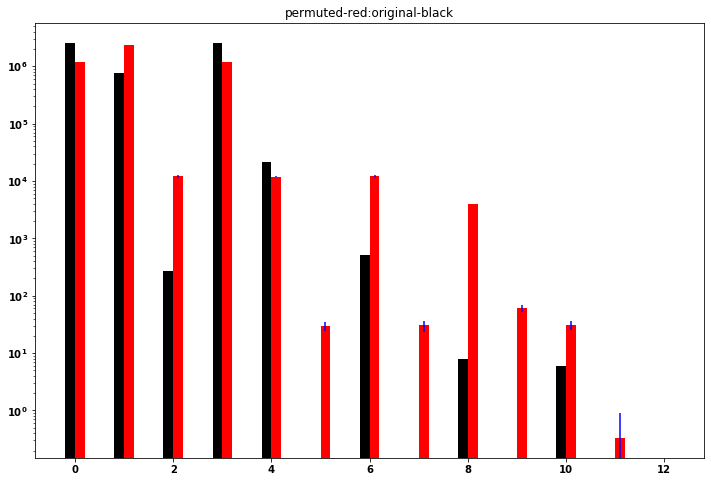

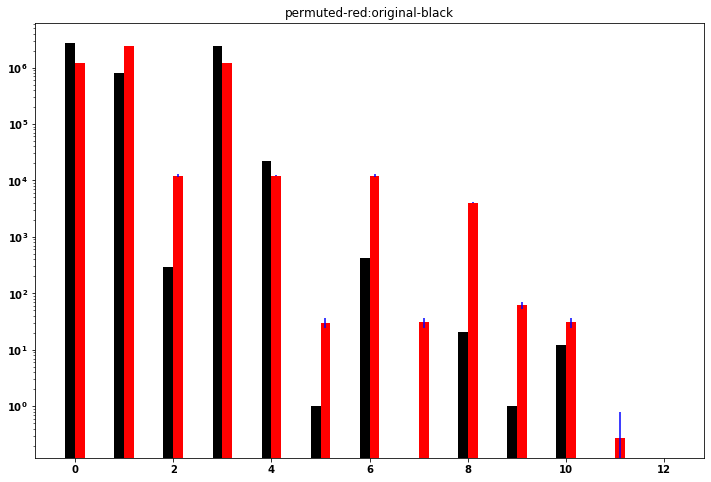

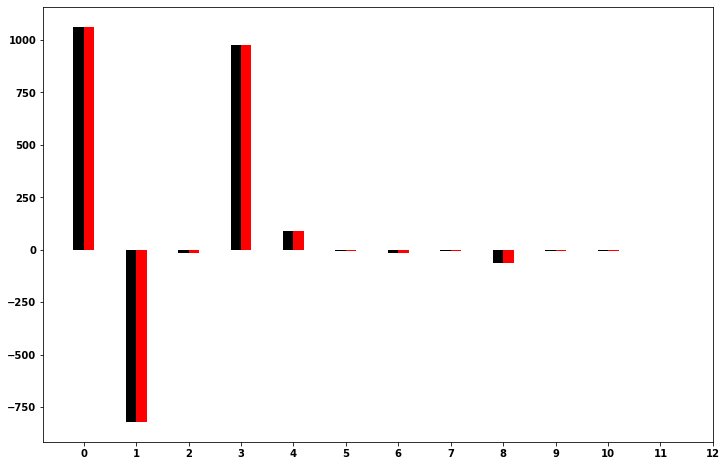

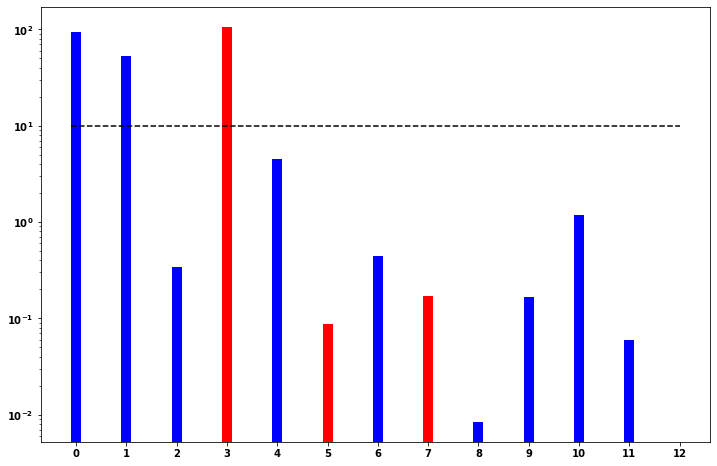

In [24]:
def plot(original_count_dict, permuted_count_dict):
    means, stds = [], []
    original = []
    keys = []
    for k in np.sort(list(original_count_dict.keys())):
        keys.append(k)
        original.append(original_count_dict[k])
        means.append(np.mean(permuted_count_dict[k]))
        stds.append(np.std(permuted_count_dict[k]))
    original = np.asarray(original)
    means    = np.asarray(means)
    stds     = np.asarray(stds)
    
    z = (original - means) / stds
    x = np.arange(len(z))
    width=0.2
    plt.figure(figsize=(12,8))
    plt.bar(x-width/2,original,width, color='k')
    plt.bar(x+width/2, means,width, color='r', yerr=stds, ecolor='b')
    plt.yscale('log')
    plt.title('permuted-red:original-black')

    return np.asarray(original), means, stds, z
   
    
baseline_original, baseline_means, baseline_stds, baseline_motif_z = plot(baseline_original_count_dict, baseline_permuted_count_dict)
presz_original, presz_means, presz_stds, presz_motif_z    = plot(presz_original_count_dict, presz_permuted_count_dict)

width=0.2
x = np.arange(len(baseline_motif_z))
# plt.figure(figsize=(12,8))
# plt.bar(x-width/2,baseline_original,width, color='k')
# plt.bar(x+width/2,presz_original,width, color='r')
# plt.yscale('log')
print('--- baseline original with presz_original')
print(list(zip(baseline_original, presz_original)))
print('--- baseline surrogate means vs presz surrogate means')
print(list(zip(baseline_means, presz_means)))
print('--- base surrogate stds vs presz surrogate stds')
print(list(zip(baseline_stds, presz_stds)))
print('----- baseline z vs presz z')
print(list(zip(baseline_motif_z, presz_motif_z)))
print('----')
print('zdiff')
print(presz_motif_z - baseline_motif_z)
print('---')
for i in range(len(baseline_original)):
    diff = presz_original[i] - baseline_original[i]
    print(i, diff / baseline_original[i])

# plt.figure(figsize=(12,8))
# plt.bar(x-width/2,baseline_means,width, color='k', yerr=baseline_stds, ecolor='b')
# plt.bar(x+width/2,presz_means,width, color='r', yerr=presz_stds, ecolor='b')
# plt.yscale('log')
# plt.show()

plt.figure(figsize=(12,8))
plt.bar(x-width/2,baseline_motif_z,width, color='k')
plt.bar(x+width/2, baseline_motif_z,width, color='r')
plt.xticks(x)
plt.show()

plt.figure(figsize=(12,8))
zdiff = presz_motif_z - baseline_motif_z
for i in range(len(zdiff)):
    if zdiff[i] >= 0: color = 'b'
    else: color='r'
    plt.bar(x[i],abs(zdiff[i]),width, color=color)
plt.xticks(x)
plt.yscale('log')
plt.hlines(10, -width/2, max(x), linestyle='--', color='k')
plt.show()

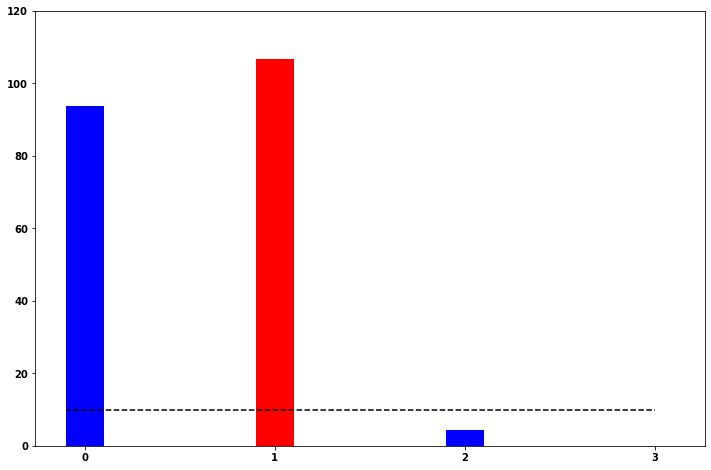

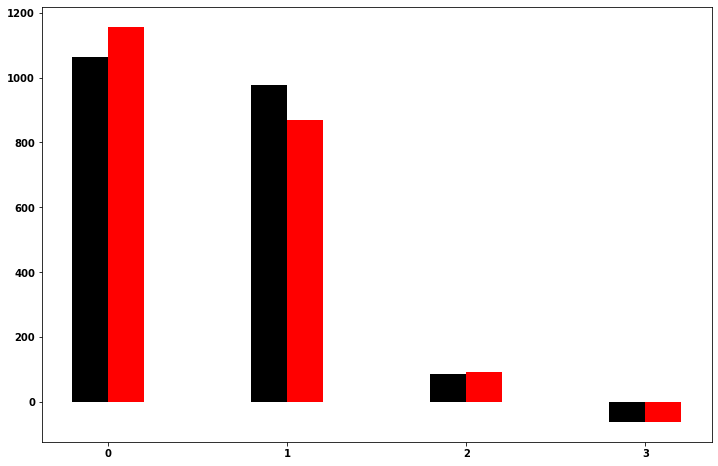

In [26]:
plt.figure(figsize=(12,8))
zdiff = presz_motif_z - baseline_motif_z
for (e,i) in enumerate([0,3,4,8]):
    if zdiff[i] >= 0: color = 'b'
    else: color='r'
    plt.bar(e,abs(zdiff[i]),width, color=color)
plt.xticks(x)
plt.hlines(10, -width/2, 3, linestyle='--', color='k')
plt.ylim([0,120])
plt.show()

width = 0.2
plt.figure(figsize=(12,8))
plt.bar(np.arange(4)-width/2,baseline_motif_z[[0,3,4,8]], width, color='k')
plt.bar(np.arange(4)+width/2, presz_motif_z[[0,3,4,8]],width, color='r')
plt.xticks(np.arange(4))
plt.show()